In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sns.set_theme(style='whitegrid')


In [ ]:
# Load only safe (non-leakage) columns for target-driven EDA
csv_path = r'C:\Users\Vido\Desktop\EPL448\accepted_2007_to_2018q4.csv\accepted_2007_to_2018q4.csv'
nrows = 150000 # how do we get the rows they are not random! 

# Safe features from Features.txt (origination-time / application-time) # how did we get the safe Features.txt?
safe_feature_cols = [
    'loan_status', 'loan_amnt', 'term', 'int_rate', 'installment',
    'grade', 'sub_grade', 'home_ownership', 'verification_status',
    'issue_d', 'purpose', 'addr_state',
    'fico_range_low', 'fico_range_high', 'revol_bal', 'revol_util',
    'dti', 'annual_inc', 'emp_length', 'emp_title', 'earliest_cr_line',
    'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'total_acc',
    'pub_rec', 'tax_liens', 'collections_12_mths_ex_med',
    'chargeoff_within_12_mths'
]

# Read header first, then keep only existing columns
header = pd.read_csv(csv_path, nrows=0)
use_cols = [c for c in safe_feature_cols if c in header.columns]

df = pd.read_csv(csv_path, usecols=use_cols, nrows=nrows, low_memory=True)
print(f'Loaded {len(df):,} rows and {df.shape[1]} columns')
print('Columns used:', use_cols)


Loaded 150,000 rows and 29 columns
Columns used: ['loan_status', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'issue_d', 'purpose', 'addr_state', 'fico_range_low', 'fico_range_high', 'revol_bal', 'revol_util', 'dti', 'annual_inc', 'emp_length', 'emp_title', 'earliest_cr_line', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'total_acc', 'pub_rec', 'tax_liens', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths']


In [ ]:
# Keep only classes useful for a binary prediction target
# 1 = bad (Charged Off), 0 = good (Fully Paid)
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()  #Why do we only do binary? We can have multilevel answer no?
df['target_loan_status'] = (df['loan_status'] == 'Charged Off').astype(int)

print(df['loan_status'].value_counts())
display(df.head(5))


loan_status
Fully Paid     105691
Charged Off     26330
Name: count, dtype: int64


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,chargeoff_within_12_mths,tax_liens,target_loan_status
0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,...,1.0,7.0,0.0,2765.0,29.7,13.0,0.0,0.0,0.0,0
1,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,...,4.0,22.0,0.0,21470.0,19.2,38.0,0.0,0.0,0.0,0
2,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,...,0.0,6.0,0.0,7869.0,56.2,18.0,0.0,0.0,0.0,0
4,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,...,3.0,12.0,0.0,21929.0,64.5,35.0,0.0,0.0,0.0,0
5,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,4 years,RENT,34000.0,...,0.0,5.0,0.0,8822.0,68.4,6.0,0.0,0.0,0.0,0


In [4]:
# Basic structure and missingness
df.info()
missing = (df.isna().mean() * 100).sort_values(ascending=False)
display(missing[missing > 0].head(20))


<class 'pandas.core.frame.DataFrame'>
Index: 132021 entries, 0 to 149999
Data columns (total 30 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   132021 non-null  float64
 1   term                        132021 non-null  object 
 2   int_rate                    132021 non-null  float64
 3   installment                 132021 non-null  float64
 4   grade                       132021 non-null  object 
 5   sub_grade                   132021 non-null  object 
 6   emp_title                   123655 non-null  object 
 7   emp_length                  123682 non-null  object 
 8   home_ownership              132021 non-null  object 
 9   annual_inc                  132021 non-null  float64
 10  verification_status         132021 non-null  object 
 11  issue_d                     132021 non-null  object 
 12  loan_status                 132021 non-null  object 
 13  purpose            

emp_title     6.336871
emp_length    6.316419
revol_util    0.037873
dti           0.001515
dtype: float64

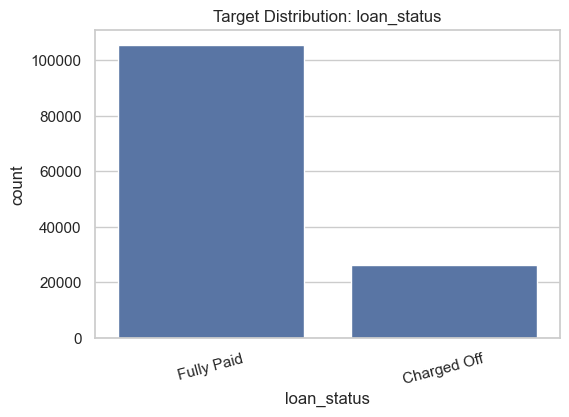

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='loan_status')
plt.title('Target Distribution: loan_status')
plt.xticks(rotation=15)
plt.show()


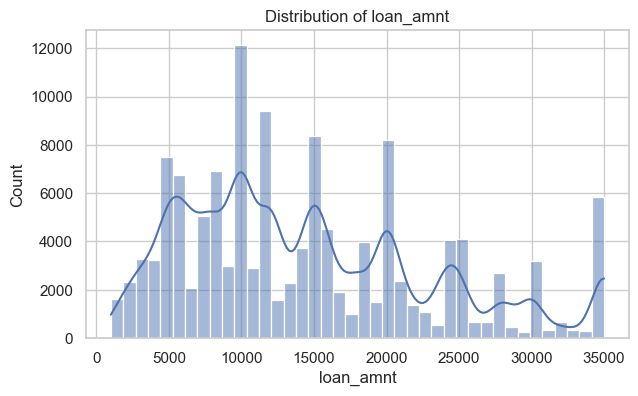

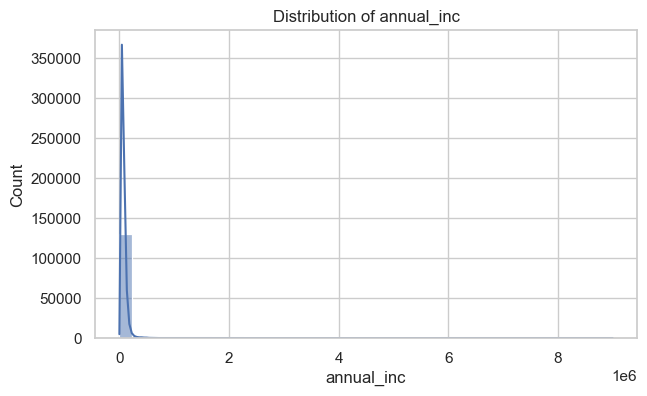

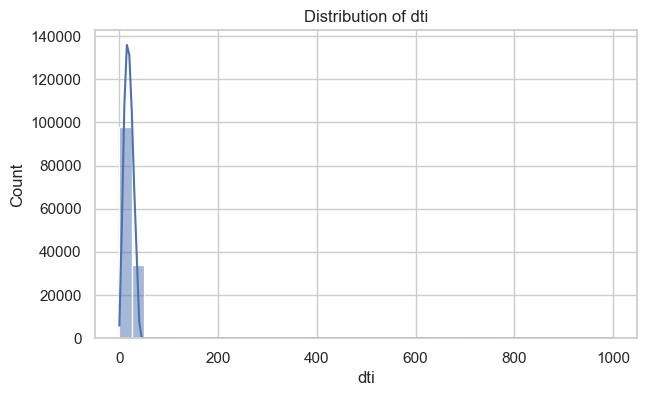

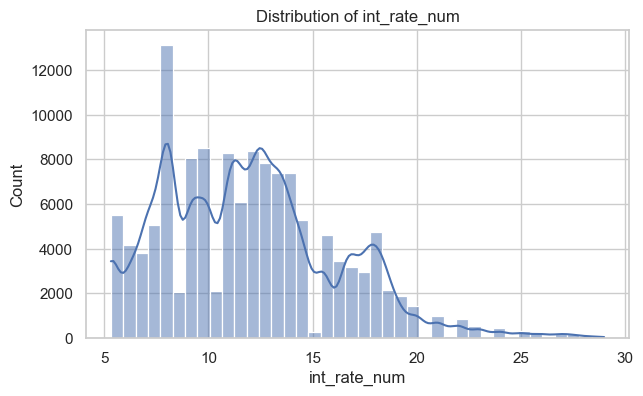

In [6]:
# Convert percentage strings for analysis
if 'int_rate' in df.columns:
    df['int_rate_num'] = pd.to_numeric(df['int_rate'].astype(str).str.replace('%','', regex=False), errors='coerce')
if 'revol_util' in df.columns:
    df['revol_util_num'] = pd.to_numeric(df['revol_util'].astype(str).str.replace('%','', regex=False), errors='coerce')

for col in ['loan_amnt', 'annual_inc', 'dti', 'int_rate_num']:
    if col in df.columns:
        plt.figure(figsize=(7,4))
        sns.histplot(data=df, x=col, kde=True, bins=40)
        plt.title(f'Distribution of {col}')
        plt.show()


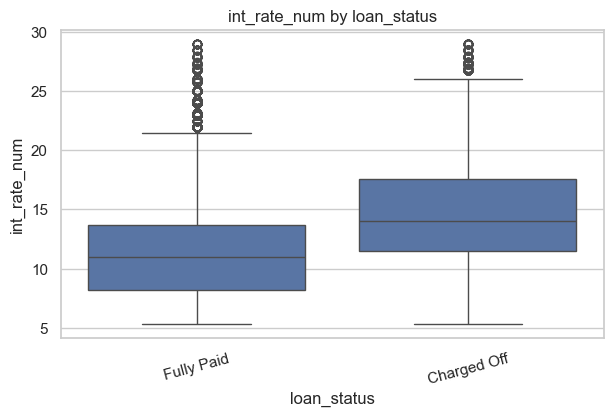

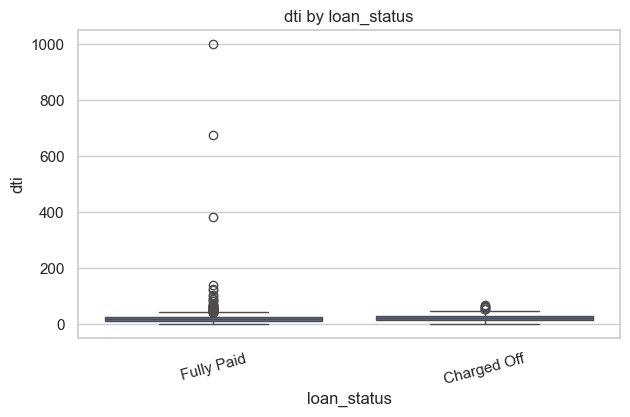

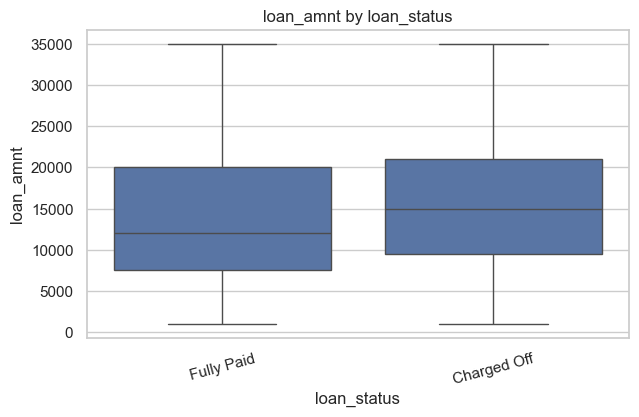

In [7]:
for col in ['int_rate_num', 'dti', 'loan_amnt']:
    if col in df.columns:
        plt.figure(figsize=(7,4))
        sns.boxplot(data=df, x='loan_status', y=col)
        plt.title(f'{col} by loan_status')
        plt.xticks(rotation=15)
        plt.show()


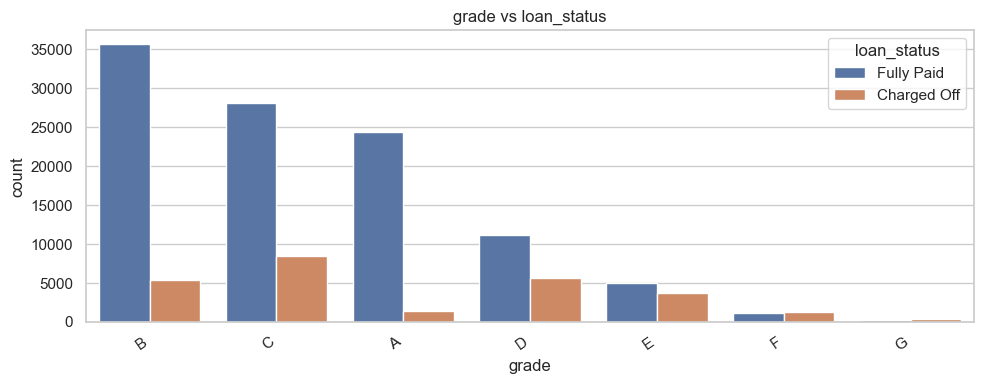

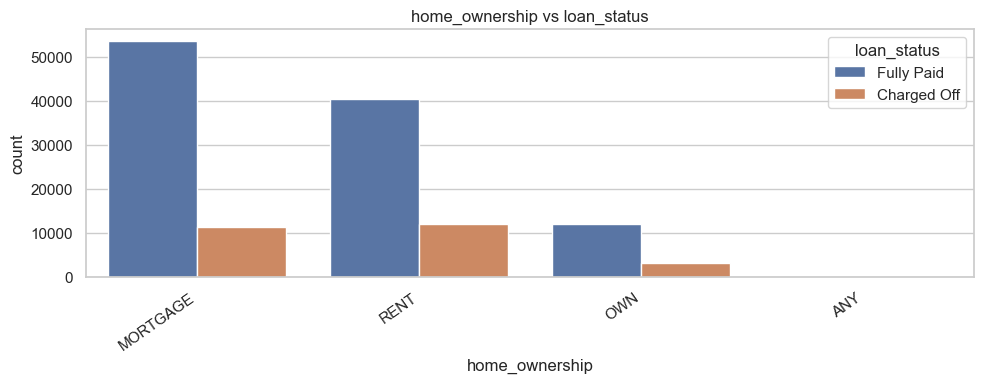

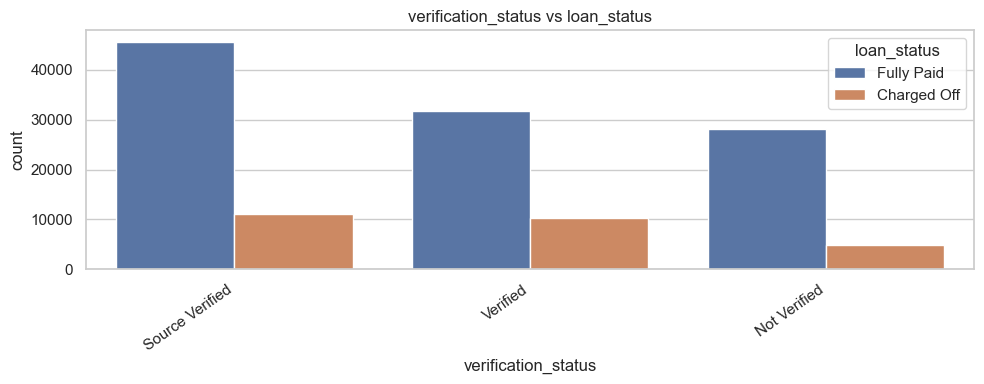

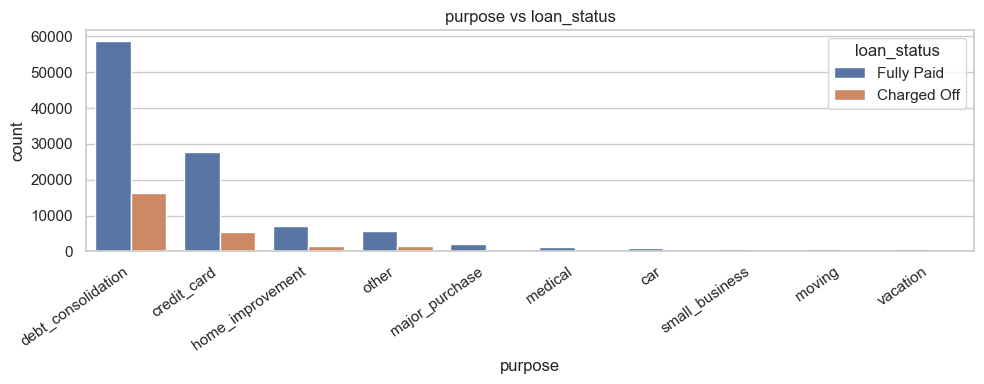

In [8]:
for cat_col in ['grade', 'home_ownership', 'verification_status', 'purpose']:
    if cat_col in df.columns:
        top_levels = df[cat_col].value_counts().head(10).index
        temp = df[df[cat_col].isin(top_levels)]
        plt.figure(figsize=(10,4))
        sns.countplot(data=temp, x=cat_col, hue='loan_status', order=top_levels)
        plt.title(f'{cat_col} vs loan_status')
        plt.xticks(rotation=35, ha='right')
        plt.tight_layout()
        plt.show()


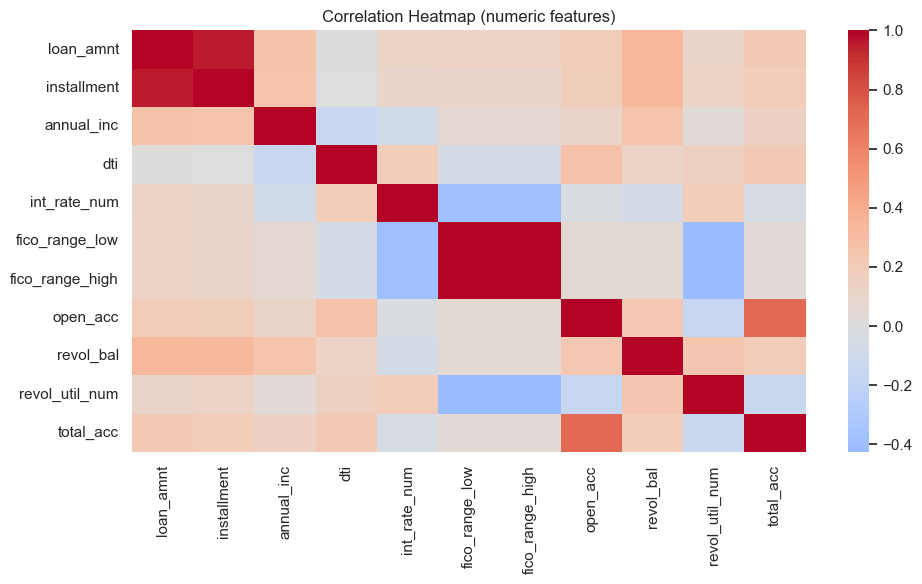

In [9]:
num_for_corr = [c for c in ['loan_amnt', 'installment', 'annual_inc', 'dti', 'int_rate_num', 'fico_range_low', 'fico_range_high', 'open_acc', 'revol_bal', 'revol_util_num', 'total_acc'] if c in df.columns]
corr = df[num_for_corr].corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (numeric features)')
plt.tight_layout()
plt.show()


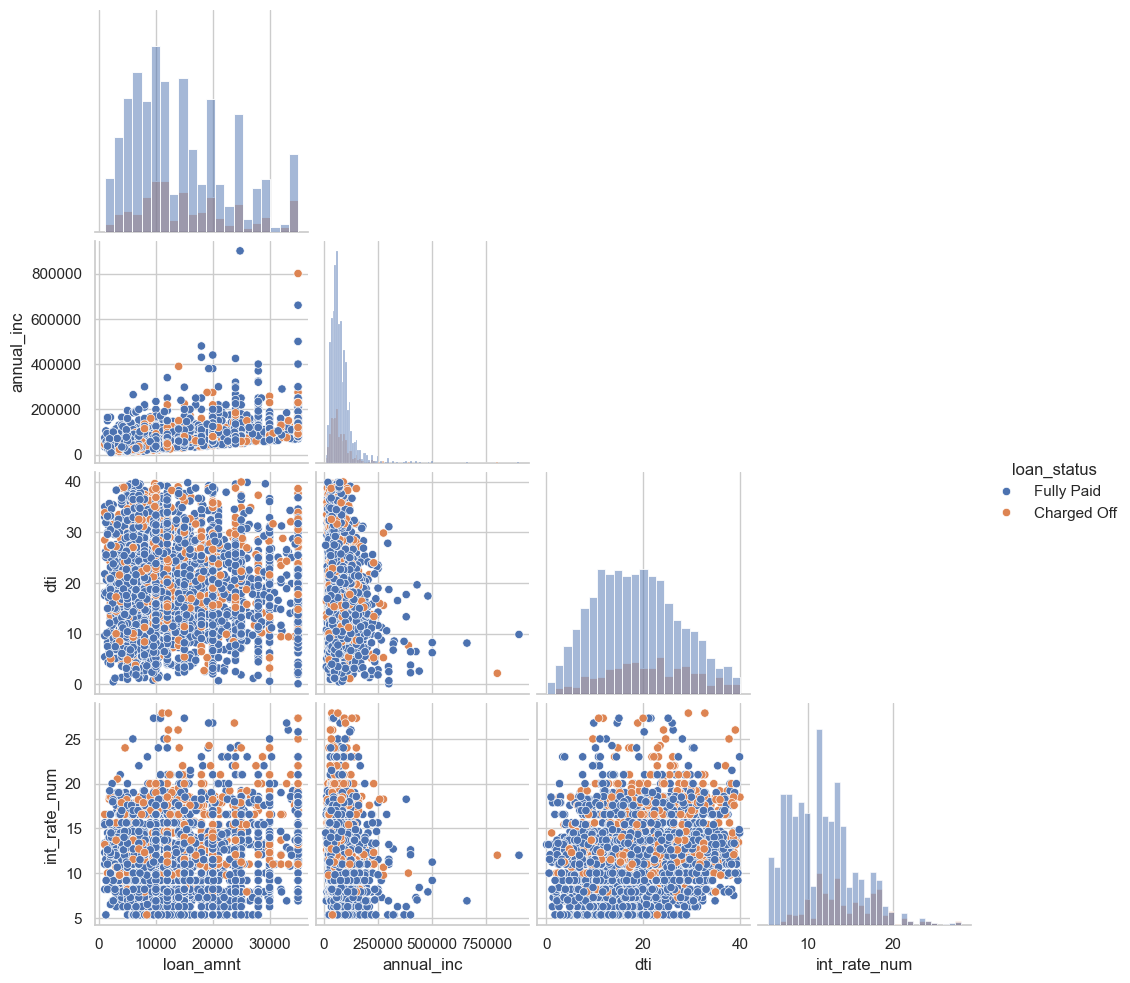

In [10]:
pair_cols = [c for c in ['loan_amnt', 'annual_inc', 'dti', 'int_rate_num'] if c in df.columns]
if len(pair_cols) >= 2:
    pair_df = df[pair_cols + ['loan_status']].dropna().sample(n=min(3000, df[pair_cols + ['loan_status']].dropna().shape[0]), random_state=42)
    sns.pairplot(pair_df, vars=pair_cols, hue='loan_status', corner=True, diag_kind='hist')
    plt.show()


In [11]:
# Helper target: 1 = Charged Off, 0 = Fully Paid
df['is_charged_off'] = (df['loan_status'] == 'Charged Off').astype(int)
print('Charged Off rate:', round(df['is_charged_off'].mean() * 100, 2), '%')


Charged Off rate: 19.94 %


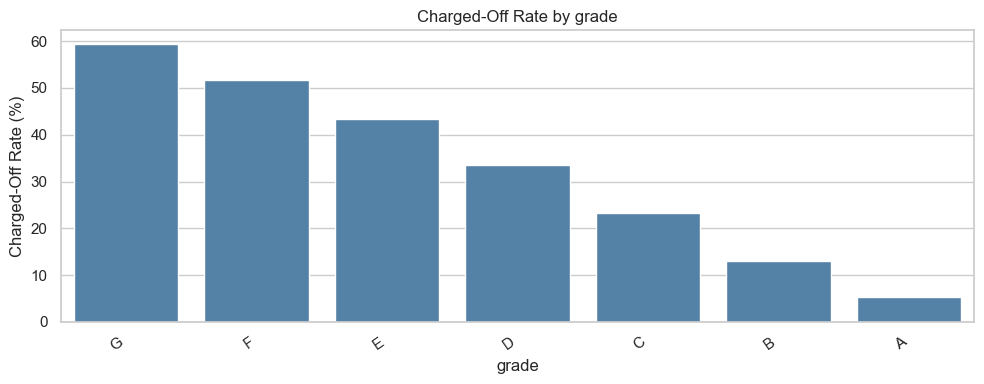

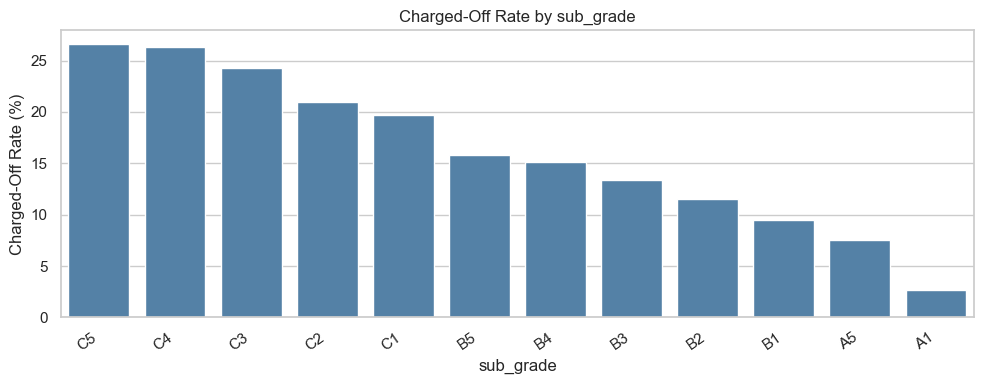

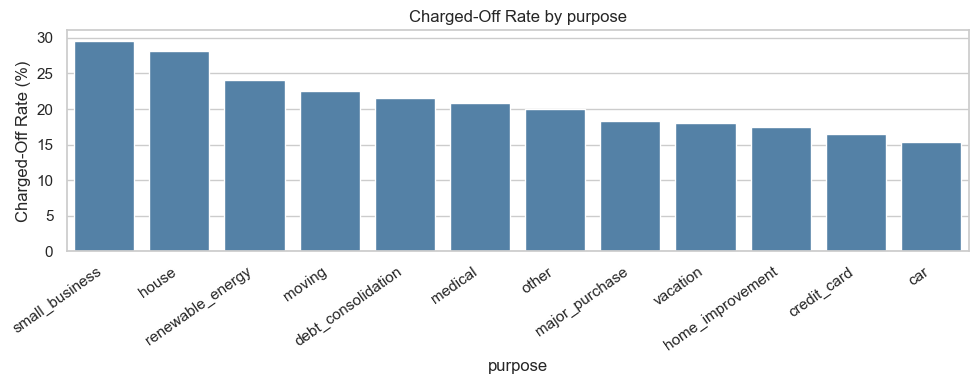

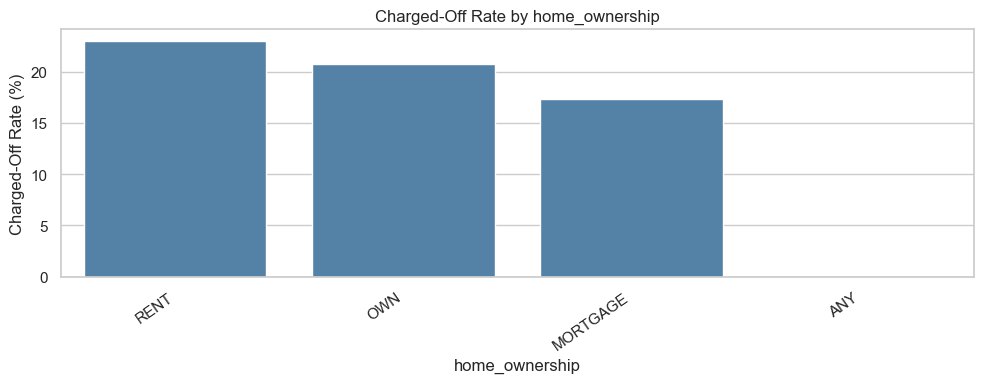

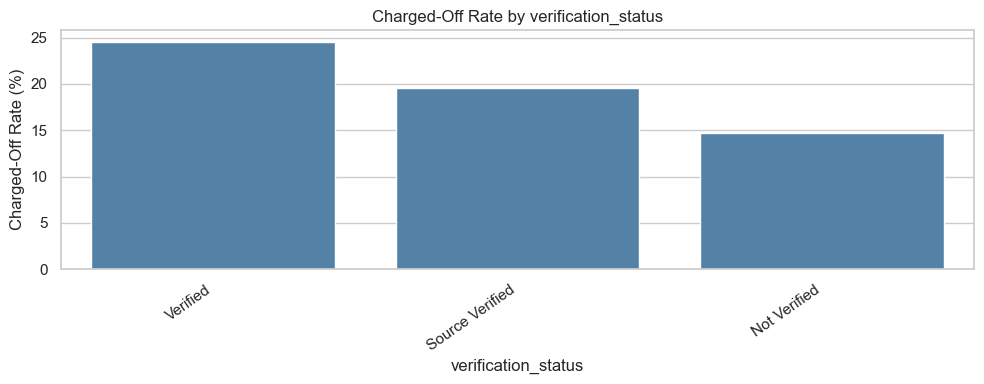

In [12]:
# 1) Bad-rate by key categorical variables (high signal view)
cat_vars = ['grade', 'sub_grade', 'purpose', 'home_ownership', 'verification_status']
for c in cat_vars:
    if c in df.columns:
        tmp = df[[c, 'is_charged_off']].dropna()
        top = tmp[c].value_counts().head(12).index
        rate = (tmp[tmp[c].isin(top)]
                  .groupby(c)['is_charged_off']
                  .mean()
                  .sort_values(ascending=False)
                  .mul(100))
        plt.figure(figsize=(10,4))
        sns.barplot(x=rate.index, y=rate.values, color='steelblue')
        plt.title(f'Charged-Off Rate by {c}')
        plt.ylabel('Charged-Off Rate (%)')
        plt.xlabel(c)
        plt.xticks(rotation=35, ha='right')
        plt.tight_layout()
        plt.show()


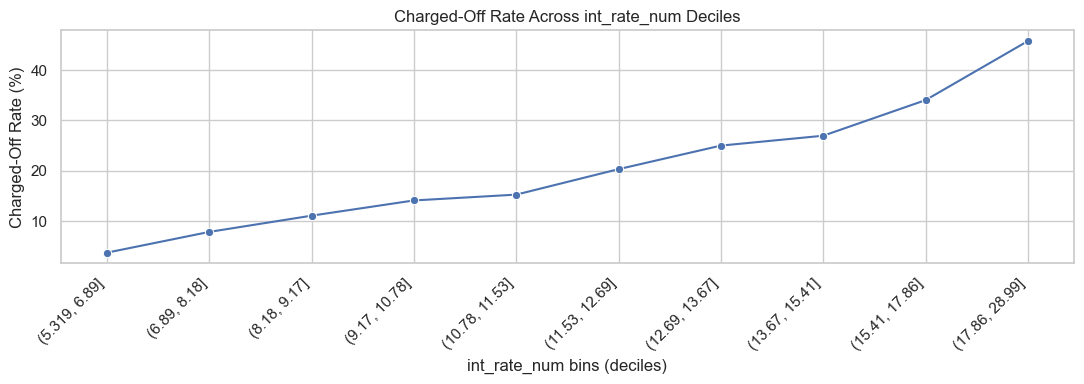

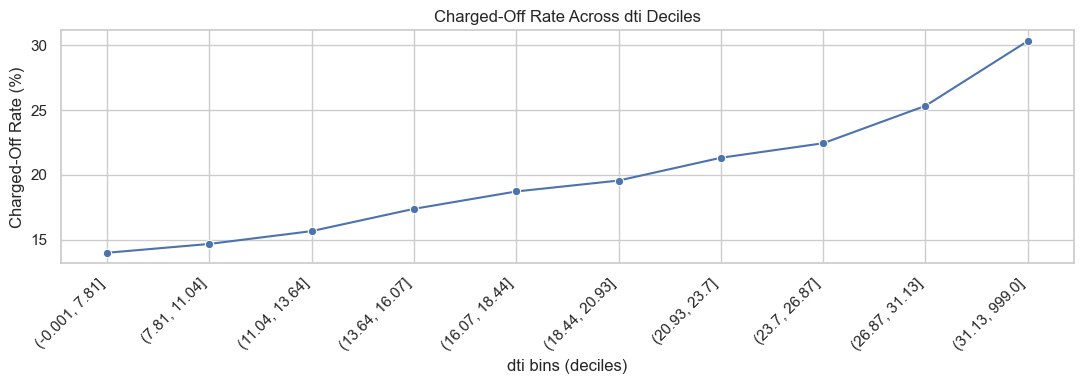

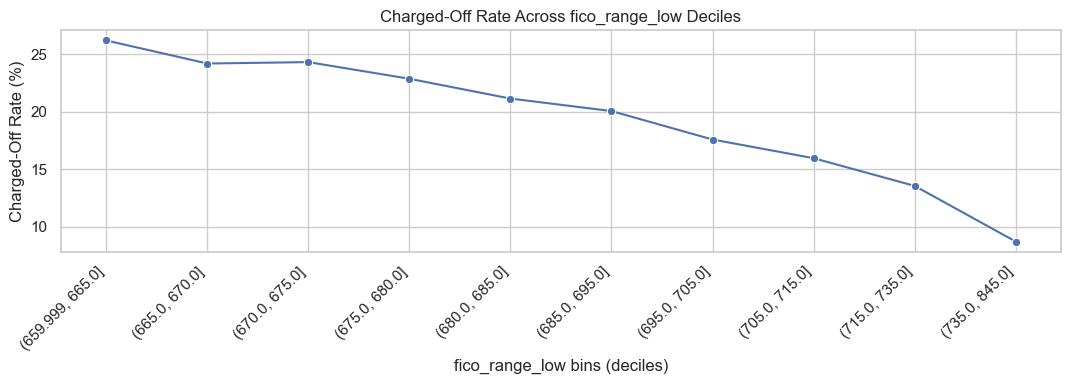

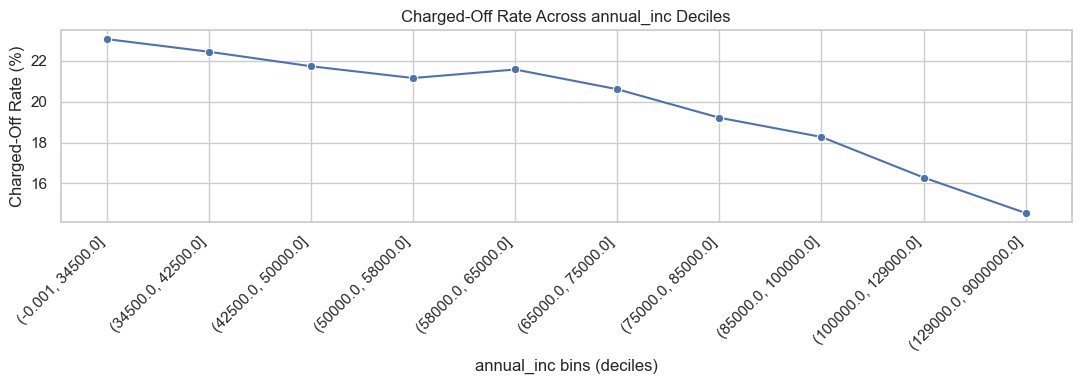

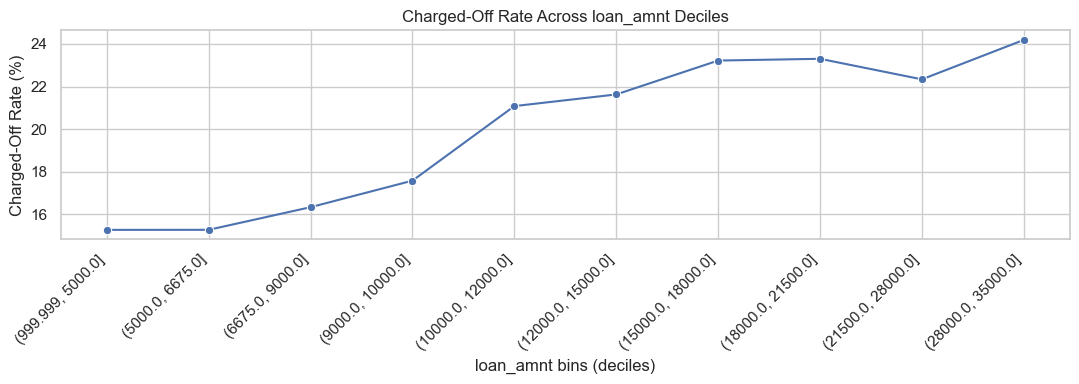

In [13]:
# 2) Bin numeric features and plot charged-off rate per bin
num_candidates = ['int_rate_num', 'dti', 'fico_range_low', 'annual_inc', 'loan_amnt']
for ncol in num_candidates:
    if ncol in df.columns:
        tmp = df[[ncol, 'is_charged_off']].dropna().copy()
        if tmp[ncol].nunique() < 10:
            continue
        tmp['bin'] = pd.qcut(tmp[ncol], q=10, duplicates='drop')
        rate = tmp.groupby('bin', observed=False)['is_charged_off'].mean().mul(100)
        plt.figure(figsize=(11,4))
        sns.lineplot(x=rate.index.astype(str), y=rate.values, marker='o')
        plt.title(f'Charged-Off Rate Across {ncol} Deciles')
        plt.ylabel('Charged-Off Rate (%)')
        plt.xlabel(f'{ncol} bins (deciles)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
